In [1]:
%reload_ext autoreload
%autoreload 2
import bmxobs
from bmxobs.SingleFreqGeometry import SingleFreqGeometry
from bmxobs.TheoryPredictor import TheoryPredictor
import fitsio
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from scipy.optimize import least_squares
import copy

In [2]:
bmxobs.__path__

['/direct/astro+u/wcook/bmxobs/bmxobs']

In [15]:
D=bmxobs.BMXSingleFreqObs("pas/210901_0000")

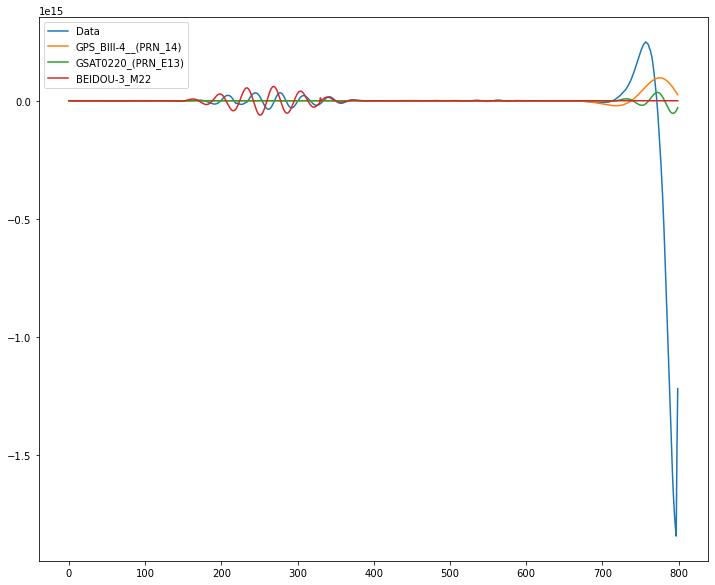

In [382]:
cut = [3000,3800]

plt.figure(figsize=(12,10))
plt.plot(D[23][cut[0]:cut[1]].real,label='Data')

for n,s in zip(D.sat_id,D.sat):
    if "COS" not in n:
        #dx= np.exp(-np.cos(s['alt'])**2/(2*0.05**2))
        track = np.array([np.cos(s['alt'])*np.cos(s['az']),np.cos(s['alt'])*np.sin(s['az'])]).T
        dx = SingleFreqGeometry().point_source(23,1,track).real
        if max(dx[cut[0]:cut[1]])>0.2:
            plt.plot(dx[cut[0]:cut[1]]*1e14,label=n)
        
plt.legend()
plt.show()

['A_GPS_BIII-4__(PRN_14)', 'A_GSAT0103_(PRN_E19)', 'A_GPS_BIIF-11_(PRN_10)', 'A_GSAT0211_(PRN_E02)', 'A_BEIDOU-3_M13_(C32)', 'A_GPS_BIIRM-4_(PRN_15)', 'A_GSAT0220_(PRN_E13)', 'A_BEIDOU-3_M5_(C21)', 'A_GSAT0209_(PRN_E09)', 'A_BEIDOU-3_M22', 'A_GPS_BIIF-9__(PRN_26)', 'A_BEIDOU-3_M12_(C26)', 'A_GPS_BIIR-8__(PRN_16)', 'A_GPS_BIIF-10_(PRN_08)', 'A_GSAT0205_(PRN_E24)', 'A_GPS_BIIR-4__(PRN_20)', 'A_BEIDOU_12_(C11)', 'A_GSAT0104_(PRN_E20)', 'A_BEIDOU-3_M11_(C25)', 'A_GSAT0222_(PRN_E33)', 'A_GPS_BIII-3__(PRN_23)', 'A_BEIDOU-3_M6_(C22)', 'A_BEIDOU-3_M8_(C30)', 'A_GSAT0217_(PRN_E27)', 'A_BEIDOU-3_M24_(C46)', 'A_GSAT0201_(PRN_E18)', 'A_BEIDOU-3_M17_(C36)', 'A_GSAT0208_(PRN_E08)', 'A_GSAT0212_(PRN_E03)', 'A_BEIDOU-3_M3_(C27)', 'A_GSAT0215_(PRN_E21)', 'A_BEIDOU_18_(C57)', 'A_GPS_BIIRM-8_(PRN_05)', 'A_GPS_BIIRM-2_(PRN_31)', 'A_GPS_BIIRM-6_(PRN_07)', 'A_GSAT0102_(PRN_E12)', 'A_GPS_BIII-2__(PRN_18)', 'A_BEIDOU-3_M1_(C19)', 'A_BEIDOU-3_M9_(C23)', 'A_GSAT0218_(PRN_E31)', 'A_GPS_BIIF-6__(PRN_06)', 'A_BEID

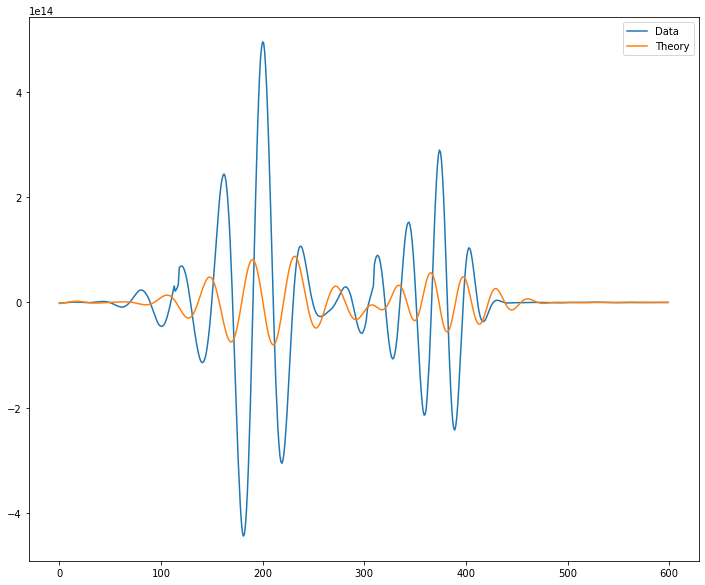

In [20]:
cut = [600,1200]

plt.figure(figsize=(12,10))
plt.plot(D[23][cut[0]:cut[1]].real,label='Data')

theory = TheoryPredictor(D)
print(theory.allParameters())
plt.plot(theory.output(23).real[cut[0]:cut[1]]*1e14,label='Theory')

plt.legend()
plt.show()

In [448]:
cut = [600,1200]
channel = 23

theory = TheoryPredictor(D, satAmp=0)
theory.setParameters({'D_all_dist':4.22254953e+00,
                      'D2_beam_center_x':8.27616094e-03,
                      'D2_beam_center_y':-12.86878858e-02,
                      'D2_phi':1.72051776e+00,
                      'D3_beam_center_x':5.95018816e-03,
                      'D3_beam_center_y':-1.59074608e-02,
                      'beam_sigma':6.84221770e-02,
                      'beam_smooth':6.37750226e-02,
                      'beam_sigma_x':4.81626917e-02,
                      'beam_smooth_y':6.55107547e-02
                     })
print(theory.allParameters())

names = ['A_GSAT0211_(PRN_E02)','A_GPS_BIIF-9__(PRN_26)'] #names of independent variables

def fitFunc(params):
    p = {}
    for i,n in enumerate(names):
        p[n] = params[i]
    theory.setParameters(p)
    prediction = theory.output(channel)[cut[0]:cut[1]]
    data = D[channel][cut[0]:cut[1]]
    return (data.real-prediction.real)/1e14

def showFunc(params):
    p = {}
    for i,n in enumerate(names):
        p[n] = params[i]
    theory.setParameters(p)
    return theory.output(channel)[cut[0]:cut[1]].real

['A_GPS_BIII-4__(PRN_14)', 'A_GSAT0103_(PRN_E19)', 'A_GPS_BIIF-11_(PRN_10)', 'A_GSAT0211_(PRN_E02)', 'A_BEIDOU-3_M13_(C32)', 'A_GPS_BIIRM-4_(PRN_15)', 'A_GSAT0220_(PRN_E13)', 'A_BEIDOU-3_M5_(C21)', 'A_GSAT0209_(PRN_E09)', 'A_BEIDOU-3_M22', 'A_GPS_BIIF-9__(PRN_26)', 'A_BEIDOU-3_M12_(C26)', 'A_GPS_BIIR-8__(PRN_16)', 'A_GPS_BIIF-10_(PRN_08)', 'A_GSAT0205_(PRN_E24)', 'A_GPS_BIIR-4__(PRN_20)', 'A_BEIDOU_12_(C11)', 'A_GSAT0104_(PRN_E20)', 'A_BEIDOU-3_M11_(C25)', 'A_GSAT0222_(PRN_E33)', 'A_GPS_BIII-3__(PRN_23)', 'A_BEIDOU-3_M6_(C22)', 'A_BEIDOU-3_M8_(C30)', 'A_GSAT0217_(PRN_E27)', 'A_BEIDOU-3_M24_(C46)', 'A_GSAT0201_(PRN_E18)', 'A_BEIDOU-3_M17_(C36)', 'A_GSAT0208_(PRN_E08)', 'A_GSAT0212_(PRN_E03)', 'A_BEIDOU-3_M3_(C27)', 'A_GSAT0215_(PRN_E21)', 'A_BEIDOU_18_(C57)', 'A_GPS_BIIRM-8_(PRN_05)', 'A_GPS_BIIRM-2_(PRN_31)', 'A_GPS_BIIRM-6_(PRN_07)', 'A_GSAT0102_(PRN_E12)', 'A_GPS_BIII-2__(PRN_18)', 'A_BEIDOU-3_M1_(C19)', 'A_BEIDOU-3_M9_(C23)', 'A_GSAT0218_(PRN_E31)', 'A_GPS_BIIF-6__(PRN_06)', 'A_BEID

In [449]:
fit = least_squares(fitFunc,[5e16,5e16], bounds = [[1e14,1e14],[5e17,5e17]])
params = fit.x
print(params)

[3.05778486e+16 2.14286132e+17]


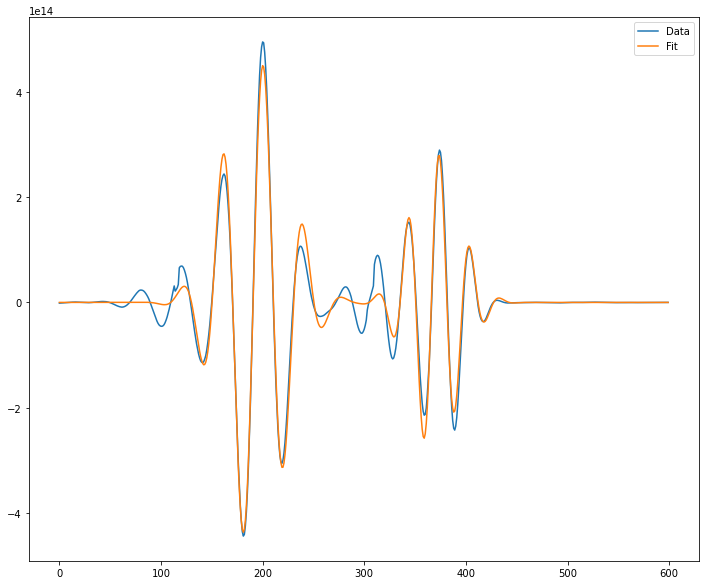

In [453]:
plt.figure(figsize=(12,10))

plt.plot(D[23][cut[0]:cut[1]].real,label='Data')

#plt.plot(theory.output(23)[cut[0]:cut[1]].real)
plt.plot(showFunc(params),label='Fit')
#plt.plot(fitFunc(params)*1e14)

plt.legend()
plt.show()